In [ ]:
# http://jamesrledoux.com/projects/open-source/2017/07/27/introducing-pybaseball.html
# https://github.com/jldbc/pybaseball

In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
import pandas as pd
import numpy as np

from pybaseball import batting_stats_range, schedule_and_record, team_batting, team_pitching
print('ready')

ready


In [3]:
# trying mike stucka's date 
def get_big_timestamp(date_object=None):
    import datetime
    if not date_object:
        date_object = datetime.datetime.now()
    stamp = ""
    # comment out below if you don't want "Wednesday" or similar in your string
    stamp += datetime.datetime.strftime(date_object, "%A, ")
    if date_object.month == 9:
        stamp += "Sept. " +  datetime.datetime.strftime(date_object, "%d, %Y").lstrip("0")
    elif date_object.month < 3 or date_object.month > 7:
        stamp += datetime.datetime.strftime(date_object, "%b. ") + datetime.datetime.strftime(date_object, "%d").lstrip("0")
    else:
        stamp += datetime.datetime.strftime(date_object, "%B ") + datetime.datetime.strftime(date_object, "%d").lstrip("0")
    # uncomment out below if you want the year
    # stamp += datetime.datetime.strftime(date_object, ", %Y")
    stamp += ", at "
    stamp += datetime.datetime.strftime(date_object, "%I:%M %p").lstrip("0").replace("AM", "a.m.").replace("PM", "p.m.")
    return(stamp)

timestamp=get_big_timestamp()
timestamp

'Thursday, April 5, at 5:38 p.m.'

In [33]:
from pybaseball import standings
data = standings()
#data

In [7]:
# Scraping baseball reference for latest standings

# this scrapes the standings page
def get_soup(year):
    url = 'http://www.baseball-reference.com/leagues/MLB/{}-standings.shtml'.format(year)
    s=requests.get(url).content
    return BeautifulSoup(s, "html.parser")

# This finds all the tables and puts each of them into a dataframe
def get_tables(soup):
    tables = soup.find_all('table')
    datasets = []
    for table in tables:
        data = []
        headings = [th.get_text() for th in table.find("tr").find_all("th")]
        data.append(headings)
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            cols.insert(0,row.find_all('a')[0]['title']) # team name
            data.append([ele for ele in cols if ele])
        datasets.append(data)
    #convert list-of-lists to dataframes
    for idx in range(len(datasets)):
        datasets[idx] = pd.DataFrame(datasets[idx])
    return datasets #returns a list of dataframes

df1 = get_soup(2018)
df2 = get_tables(df1)

print('tables gotten')

# This grabs each dataframe, labels league and division, appends and saves csv

df_standings = pd.DataFrame()

AMeast = df2[0]
AMeast.columns = AMeast.iloc[0]
AMeast = AMeast.reindex(AMeast.index.drop(0))
df_standings = df_standings.append(AMeast)
AMcent = df2[1]
AMcent.columns = AMcent.iloc[0]
AMcent = AMcent.reindex(AMcent.index.drop(0))
df_standings = df_standings.append(AMcent)
AMwest = df2[2]
AMwest.columns = AMwest.iloc[0]
AMwest = AMwest.reindex(AMwest.index.drop(0))
df_standings = df_standings.append(AMwest)
NAeast = df2[3]
NAeast.columns = NAeast.iloc[0]
NAeast = NAeast.reindex(NAeast.index.drop(0))
df_standings = df_standings.append(NAeast)
NAcent = df2[4]
NAcent.columns = NAcent.iloc[0]
NAcent = NAcent.reindex(NAcent.index.drop(0))
df_standings = df_standings.append(NAcent)
NAwest = df2[5]
NAwest.columns = NAwest.iloc[0]
NAwest = NAwest.reindex(NAwest.index.drop(0))
df_standings = df_standings.append(NAwest)

df_standings.rename(columns={'W-L%':'WLperc'}, inplace=True)

print('standings appended')

# now scraping www.fangraphs.com for pitching and batting stats 

batting = team_batting(start_season='2018', end_season=None, league='all', ind=1)
newbat = batting[['Team','R','RBI','HR','AVG','OBP','SLG','wOBA', 'wRC+','WAR']]
newbat = newbat.rename(columns={'wRC+':'wRCplus','WAR':'WARbat','AVG':'AVGbat'})

print('batting stats done')

pitching = team_pitching(start_season='2018', end_season=None, league='all', ind=1)
newpitch = pitching[['Team','ERA','SV','IP','BABIP','FIP','xFIP','WAR']]
newpitch = newpitch.rename(columns={'WAR':'WARpitch'})

print('pitching stats done')

#Joining standings with bballjoin
bballJoin = pd.read_csv('csv/bballJoin.csv', index_col=None)
left = df_standings
right = bballJoin
result = pd.merge(left, right, how='left', left_on='Tm', right_on='Tm', suffixes=('_x', '_y'))
print('1st standings join done')

# now joining batting stats
left = result
right = newbat
result2 = pd.merge(left, right, how='left', left_on='Team', right_on='Team', suffixes=('_x', '_y'))
print('batting stats joined')

# finally join pitching stats
left = result2
right = newpitch
result3 = pd.merge(left, right, how='left', left_on='Team', right_on='Team', suffixes=('_x', '_y'))
print('pitching stats joined')

result3.to_csv("csv/standings.csv", index=False, encoding="utf-8")
print('standings file done and saved')

tables gotten
standings file done


In [37]:
#df_standings.dtypes

In [22]:
#batting.dtypes
# stats via www.fangraphs.com
# wOBA Weighted On-Base Average - kind of combining batting average, on-base percentage, and slugging percentage
# https://www.fangraphs.com/library/offense/woba/
# wRC+ player’s total offensive value measured by runs, adjusted for league and park
# https://www.fangraphs.com/library/offense/wrc/
# WAR
# https://www.fangraphs.com/library/misc/war/


In [27]:
#pitching.dtypes
# stats via # stats via www.fangraphs.com
# Batting Average on Balls In Play (BABIP) measures how often a ball in play goes for a hit.
# Fielding Independent Pitching (FIP) measures what a player’s ERA would look like over a given period of time 
# if the pitcher were to have experienced league average results on balls in play and league average timing
# https://www.fangraphs.com/library/pitching/FIP/
# Expected Fielding Independent Pitching (xFIP) is a regressed version of FIP
# calculated in the same way as FIP, except it replaces a pitcher’s home run total 
# with an estimate of how many home runs they should have allowed given other factors.
# https://www.fangraphs.com/library/pitching/xFIP/

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
%matplotlib inline

#-----
# set styles

mpl.rcParams['font.family'] = ['sans-serif']
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 0.75

mpl.rcParams['pdf.fonttype'] = 42 # allegedly allows text to be saved as editable

mpl.rcParams['font.sans-serif'] = ['Arial Narrow']
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = False
mpl.rcParams['svg.fonttype'] = 'none'

import warnings
warnings.filterwarnings("ignore")

plt.style.use(['ggplot'])
# prints list of available seaborn styles
#print(plt.style.available)

from scipy.stats import norm

print('ready')

ready


In [3]:
df = pd.read_csv('csv/standings.csv', index_col=None)

df.dtypes

Tm           object
W             int64
L             int64
WLperc      float64
GB           object
Team         object
League       object
Division     object
color        object
R           float64
RBI         float64
HR          float64
AVGbat      float64
OBP         float64
SLG         float64
wOBA        float64
wRCplus     float64
WARbat      float64
ERA         float64
SV          float64
IP          float64
BABIP       float64
FIP         float64
xFIP        float64
WARpitch    float64
dtype: object

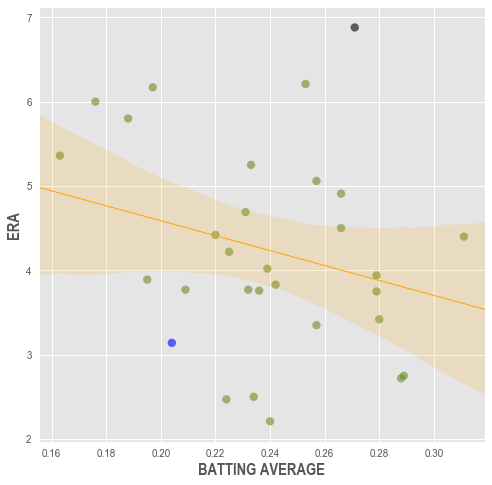

In [20]:
g = sns.regplot(data=df, x='AVGbat', y='ERA',
                fit_reg=True,
                scatter_kws={'facecolors':df['color'],"alpha":0.6,"s":70},
                line_kws={"color":"orange","lw":1}
               )

# Set the size of the graph from here
g.figure.set_size_inches(8,8)
#plt.suptitle('Batting average vs. ERA', fontsize=16, family='Arial Black', y=.94)
plt.ylabel('ERA', fontsize=16, fontweight='bold')
plt.xlabel('BATTING AVERAGE', fontsize=16, fontweight='bold')

g.figure.savefig('static/img/BAvERA.png',bbox_inches='tight')

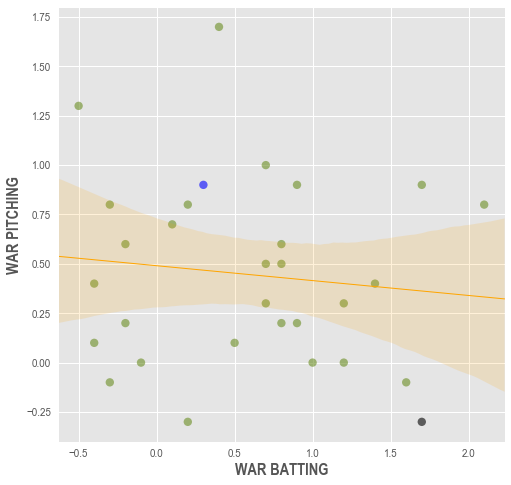

In [13]:
g = sns.regplot(data=df, x='WARbat', y='WARpitch',
                fit_reg=True,
                scatter_kws={'facecolors':df['color'],"alpha":0.6,"s":70},
                line_kws={"color":"orange","lw":1}
               )

# Set the size of the graph from here
g.figure.set_size_inches(8,8)
#plt.suptitle('Batting average vs. ERA', fontsize=16, family='Arial Black', y=.94)
plt.ylabel('WAR PITCHING', fontsize=16, fontweight='bold')
plt.xlabel('WAR BATTING', fontsize=16, fontweight='bold')

g.figure.savefig('static/img/WAR.png',bbox_inches='tight')

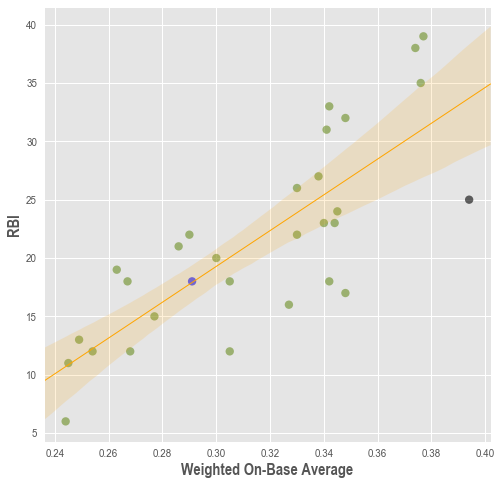

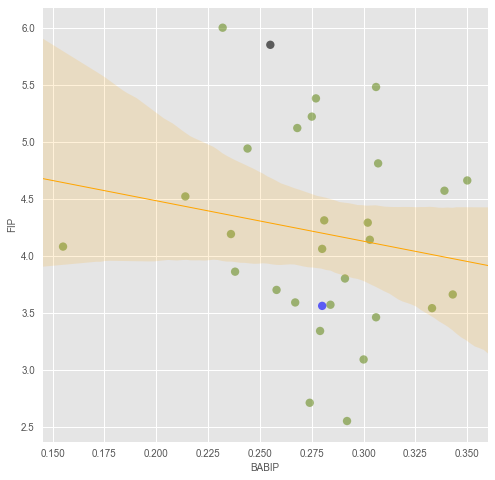

In [31]:
plt.figure()
g = sns.regplot(data=df, x='wOBA', y='RBI',
                fit_reg=True,
                scatter_kws={'facecolors':df['color'],"alpha":0.6,"s":70},
                line_kws={"color":"orange","lw":1}
               )
g.figure.set_size_inches(8,8)
plt.ylabel('RBI', fontsize=16, fontweight='bold')
plt.xlabel('Weighted On-Base Average', fontsize=16, fontweight='bold')
g.figure.savefig('static/img/offense.png',bbox_inches='tight')

plt.figure()
g1 = sns.regplot(data=df, x='BABIP', y='FIP',
                fit_reg=True,
                scatter_kws={'facecolors':df['color'],"alpha":0.6,"s":70},
                line_kws={"color":"orange","lw":1}
               )
g1.figure.set_size_inches(8,8)
#plt.ylabel('Fielding Independent Pitching', fontsize=16, fontweight='bold')
#plt.xlabel('Batting Average on Balls In Play', fontsize=16, fontweight='bold')
g1.figure.savefig('static/img/defense.png',bbox_inches='tight')

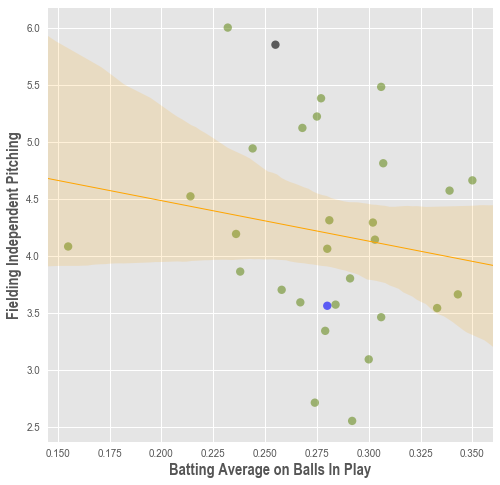

In [27]:
g = sns.regplot(data=df, x='BABIP', y='FIP',
                fit_reg=True,
                scatter_kws={'facecolors':df['color'],"alpha":0.6,"s":70},
                line_kws={"color":"orange","lw":1}
               )

# Set the size of the graph from here
g.figure.set_size_inches(8,8)
plt.ylabel('Fielding Independent Pitching', fontsize=16, fontweight='bold')
plt.xlabel('Batting Average on Balls In Play', fontsize=16, fontweight='bold')

g.figure.savefig('static/img/defense.png',bbox_inches='tight')

In [23]:
# gets descriptive info for all games in a year

sox = schedule_and_record(2018, 'CHW')
cubs = schedule_and_record(2018, 'CHC')

print('ready')

ready


In [4]:
sox.describe()

,R,RA,Inn,Rank,Attendance,Streak
count,3.000000,3.000000,3.0,3.0,3.000000,3.000000
mean,6.666667,4.666667,9.0,1.0,23570.000000,0.666667
std,6.429101,2.081666,0.0,0.0,11222.172829,1.527525
min,2.000000,3.000000,9.0,1.0,16629.000000,-1.000000
25%,3.000000,3.500000,9.0,1.0,17096.500000,0.000000
50%,4.000000,4.000000,9.0,1.0,17564.000000,1.000000
75%,9.000000,5.500000,9.0,1.0,27040.500000,1.500000
max,14.000000,7.000000,9.0,1.0,36517.000000,2.000000


In [5]:
cubs.describe()

,R,RA,Inn,Rank,Attendance,Streak
count,5.000000,5.000000,5.00000,5.000000,5.00000,5.000000
mean,3.800000,3.800000,10.80000,2.600000,17399.60000,-0.400000
std,4.816638,2.280351,3.49285,1.140175,8849.60724,1.341641
min,0.000000,1.000000,9.00000,1.000000,10428.00000,-2.000000
25%,0.000000,2.000000,9.00000,2.000000,12034.00000,-1.000000
50%,1.000000,4.000000,9.00000,3.000000,13422.00000,-1.000000
75%,8.000000,6.000000,10.00000,3.000000,18963.00000,1.000000
max,10.000000,6.000000,17.00000,4.000000,32151.00000,1.000000


In [18]:
# gets daily record
schedRec = schedule_and_record(2018, "CHW")
wsSched = pd.DataFrame ( schedRec.loc[ ( schedRec["W/L"].notnull() ) ] )
wsSched

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak,Orig. Scheduled
1,"Thursday, Mar 29",CHW,@,KCR,W,14.0,7.0,9.0,1-0,1.0,up 0.5,Shields,Duffy,None,3:26,D,36517.0,1.0,None
2,"Saturday, Mar 31",CHW,@,KCR,W,4.0,3.0,9.0,2-0,1.0,up 1.0,Farquhar,Maurer,Soria,2:54,N,17564.0,2.0,None
3,"Monday, Apr 2",CHW,@,TOR,L,2.0,4.0,9.0,2-1,1.0,up 0.5,Oh,Farquhar,Osuna,2:51,N,16629.0,-1.0,None


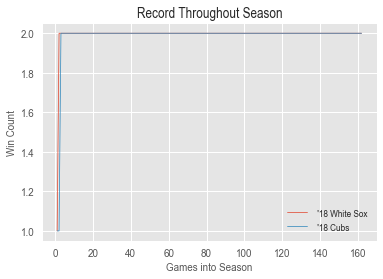

In [24]:
# create a numeric indicator of a win and take cumulative sum of wins-to-date at each point in the season
sox['win-count'] = np.where(sox['W/L']=='W', 1, 0).cumsum()
cubs['win-count'] = np.where(cubs['W/L']=='W', 1, 0).cumsum()

plt.plot(sox['win-count'],label=" '18 White Sox")
plt.plot(cubs['win-count'],label=" '18 Cubs")
plt.legend(loc=4)
plt.xlabel('Games into Season')
plt.ylabel('Win Count')
plt.title('Record Throughout Season');

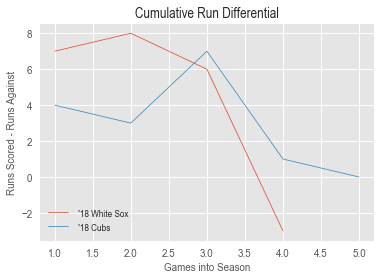

In [25]:
#Who had the largest win margins? 
sox['scorediff'] = (sox['R'] - sox['RA']).cumsum()
cubs['scorediff'] = (cubs['R'] - cubs['RA']).cumsum()
plt.plot(sox['scorediff'],label=" '18 White Sox")
plt.plot(cubs['scorediff'],label=" '18 Cubs")
plt.legend(loc=3)
plt.xlabel('Games into Season')
plt.ylabel('Runs Scored - Runs Against')
plt.title('Cumulative Run Differential');

In [3]:
batrange = batting_stats_range('2018-03-29', '2017-04-03')
ws_batrange = pd.DataFrame ( batrange.loc[ ( batrange["Lev"] == "MLB-AL") & ( batrange["Tm"] == "Chicago") ] )
ws_batrange.head(10)
print(ws_batrange.shape)

(21, 27)


In [48]:
newpitch = pitching[pitching.Team.isin(SoxCubs)]
newpitch = newpitch[['Team','ERA','W','L','SV','IP','SO','BB/9','HR/9','LOB%']]
newpitch

,Team,ERA,W,L,SV,IP,SO,BB/9,HR/9,LOB%
7,Cubs,3.95,92.0,70.0,38.0,1447.1,1439.0,3.44,1.21,0.742
25,White Sox,4.78,67.0,95.0,25.0,1421.2,1193.0,4.00,1.53,0.724


In [42]:
# select only Sox and Cubs
SoxCubs = ['White Sox','Cubs']
newbat = batting[batting.Team.isin(SoxCubs)]
newbat = newbat[['Team','AVG','G','PA','HR','R','RBI','SB','BB%','K%','OBP','SLG']]
newbat

,Team,AVG,G,PA,HR,R,RBI,SB,BB%,K%,OBP,SLG
5,Cubs,0.255,2420.0,6283.0,223.0,822.0,785.0,62.0,0.099,0.223,0.338,0.437
24,White Sox,0.256,2289.0,6059.0,186.0,706.0,670.0,71.0,0.066,0.231,0.314,0.417


In [66]:
from pybaseball import bwar_bat
bwarbat = bwar_bat(return_all=True)
bwarbat.dtypes

name_common            object
age                   float64
mlb_ID                float64
player_ID              object
year_ID                 int64
team_ID                object
stint_ID                int64
lg_ID                  object
PA                    float64
G                       int64
Inn                   float64
runs_bat              float64
runs_br               float64
runs_dp               float64
runs_field            float64
runs_infield          float64
runs_outfield         float64
runs_catcher          float64
runs_good_plays       float64
runs_defense          float64
runs_position         float64
runs_position_p       float64
runs_replacement      float64
runs_above_rep        float64
runs_above_avg        float64
runs_above_avg_off    float64
runs_above_avg_def    float64
WAA                   float64
WAA_off               float64
WAA_def               float64
WAR                   float64
WAR_def               float64
WAR_off               float64
WAR_rep   

In [93]:
SoxBwar = ['CHW']
batYear = ['2017']
Soxbat = bwarbat[bwarbat.team_ID.isin(SoxBwar)]
Soxbat = Soxbat[Soxbat.year_ID.isin(batYear)]
Soxbat.to_csv("Soxbat.csv", index=False, encoding="utf-8")
Soxbat = Soxbat[['name_common','mlb_ID','team_ID','player_ID','pitcher','G','PA','salary','runs_above_avg','runs_above_avg_off','runs_above_avg_def']]
Soxbat = Soxbat.fillna('')
Soxbat.head()

,name_common,mlb_ID,team_ID,player_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def
235,Jose Abreu,547989.0,CHW,abreujo02,N,156,675,1.0825e+07,23.5,23.5,-9.4
826,Al Alburquerque,456379.0,CHW,albural01,,0,,,,,
2029,Tim Anderson,641313.0,CHW,anderti01,N,146,606,850000,-12.3,-4.3,-0.4
2649,Cody Asche,605125.0,CHW,ascheco01,N,19,62,535000,-10.9,-10.9,-1.5
5370,Chris Beck,571476.0,CHW,beckch02,Y,5,0,,0,0,0


In [72]:
# to get mlb id
print(Soxbat["mlb_ID"][235].astype("int64"))

547989


In [83]:
# This is individual batting data
from pybaseball import statcast_batter
abreau = statcast_batter('2017-07-15', player_id = Soxbat["mlb_ID"][235].astype("int64"))

In [87]:
abreau = abreau.fillna('')
abreau.to_csv("abreau.csv", index=False, encoding="utf-8")
abreau


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number
0,SL,2017-07-15,87.5,-2.1982,5.4792,Jose Abreu,547989,621242,strikeout,swinging_strike,...,54.0768,0.000,0.000,0,1,0,0,,73,4
1,SL,2017-07-15,88.5,-2.3139,5.4066,Jose Abreu,547989,621242,,called_strike,...,53.8406,0.000,0.000,,,,,,73,3
2,SL,2017-07-15,88.2,-2.4172,5.4160,Jose Abreu,547989,621242,,swinging_strike,...,54.0338,0.000,0.000,,,,,,73,2
3,FT,2017-07-15,97.4,-2.1195,5.3026,Jose Abreu,547989,621242,,ball,...,53.4762,0.000,0.000,,,,,,73,1
4,SI,2017-07-15,94.8,-2.1022,5.9397,Jose Abreu,547989,543964,field_out,hit_into_play,...,54.2851,0.248,0.226,0,1,0,0,2,58,3
5,SI,2017-07-15,94.6,-1.9999,6.0143,Jose Abreu,547989,543964,,called_strike,...,54.2177,0.000,0.000,,,,,,58,2
6,SI,2017-07-15,91.8,-2.0500,6.0277,Jose Abreu,547989,543964,,ball,...,54.2604,0.000,0.000,,,,,,58,1
7,SI,2017-07-15,88.4,-2.1629,6.2168,Jose Abreu,547989,433587,hit_by_pitch,hit_by_pitch,...,53.9083,0.000,0.000,0.7,1,0,0,,41,1
8,CH,2017-07-15,83.7,-2.3981,6.1019,Jose Abreu,547989,433587,hit_by_pitch,hit_by_pitch,...,54.4258,0.000,0.000,0.7,1,0,0,,22,1
9,CH,2017-07-15,85.9,-2.6274,5.8621,Jose Abreu,547989,433587,field_out,hit_into_play,...,54.2907,0.099,0.093,0,1,0,0,2,6,2


In [4]:
# Working with MLB lookup service
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json

In [5]:
# Getting White Sox roster
request='http://lookup-service-prod.mlb.com/json/named.roster_40.bam?team_id=145'
data= requests.get(request)
roster=data.json()
CWS=json_normalize(roster)
CWS.columns = CWS.columns.map(lambda x: x.split(".")[-1])
work = CWS['row']
df = json_normalize(work[0])
df.to_csv("roster.csv", index=False, encoding="utf-8")
df.head(3)

,bats,birth_date,college,end_date,height_feet,height_inches,jersey_number,name_display_first_last,name_display_last_first,name_first,...,pro_debut_date,start_date,starter_sw,status_code,team_abbrev,team_code,team_id,team_name,throws,weight
0,R,1987-01-29T00:00:00,,,6,3,79,Jose Abreu,"Abreu, Jose",Jose,...,2014-03-31T00:00:00,2013-10-29T00:00:00,N,A,CWS,cha,145,Chicago White Sox,R,255
1,R,1996-09-11T00:00:00,,,6,3,77,Micker Adolfo,"Adolfo, Micker",Micker,...,,2017-11-20T00:00:00,N,RM,CWS,cha,145,Chicago White Sox,R,200
2,R,1993-06-23T00:00:00,"East Central CC, MS",,6,1,7,Tim Anderson,"Anderson, Tim",Timothy,...,2016-06-10T00:00:00,2016-06-10T00:00:00,N,A,CWS,cha,145,Chicago White Sox,R,185


In [256]:
# Getting Abreau hitting stats
request='http://lookup-service-prod.mlb.com/json/named.sport_hitting_tm.bam?sport_hitting_tm.season=2017&game_type=%27R%27&league_list_id=%27mlb%27&player_id=547989'
data= requests.get(request)
josejson=data.json()
dfJose=json_normalize(josejson)
dfJose.columns = ['copyRight','created','ab','ao','avg','babip','bb','cs','d','end_date','g','gidp','gidp_opp','go','go_ao','h','hbp','hfly','hgnd','hldr','hpop','hr','ibb','league','league_full','league_id','league_short','lob','np','obp','ops','player_id','ppa','r','rbi','roe','sac','sb','season','sf','slg','so','sport','sport_code','sport_id','t','tb','team_abbrev','team_full','team_id','team_seq','team_short','tpa','wo','xbh','totalSize']
dfJose['player'] = Soxbat["name_common"][235]
dfJose = dfJose[['player','player_id','ab','ao','avg','babip','bb','cs','d','g','gidp','gidp_opp','go','go_ao','h','hbp','hfly','hgnd','hldr','hpop','hr','ibb','league','league_full','league_id','league_short','lob','np','obp','ops','player_id','ppa','r','rbi','roe','sac','sb','season','sf','slg','so','sport','sport_code','sport_id','t','tb','team_abbrev','team_full','team_id','team_seq','team_short','tpa','wo','xbh']]
dfJose.to_csv("abreauHitting.csv", index=False, encoding="utf-8")
dfJose

,player,player_id,ab,ao,avg,babip,bb,cs,d,g,...,t,tb,team_abbrev,team_full,team_id,team_seq,team_short,tpa,wo,xbh
0,Jose Abreu,547989,621,158,.304,.330,35,0,43,156,...,6,343,CWS,Chicago White Sox,145,1,Chi White Sox,675,1,82


In [80]:
#from pybaseball import statcast
#CWS = statcast('2017-08-01', '2017-08-30', team='CWS')
# This is pitching info